In [116]:
import math

In [117]:
# reading input
# t = []
# for line in sys.stdin:
#     if '\n' == line.rstrip():
#         break
#     data = line.split()
#     t.append(data[0])
train_data = {} # {class: [tuple_nums]}
tuples = [] # [{attr: value}]
test_data = [] # [tuple_num]

homepath="./dt_debug_testcases/"
filename = "input24.txt"
file = open(homepath+filename, 'r')
Lines = file.readlines()
tuple_num = 0
for line in Lines:
    data = line.split()
    classification = int(data[0])
    if classification != -1:
        if classification in train_data:
            train_data[classification].append(tuple_num)
        else:
            train_data[classification] = [tuple_num]
    else:
        test_data.append(tuple_num)
    tuple_attrs = {}
    for i in range(1, len(data)):
        attr_val_str = data[i].split(':')
        attr = int(attr_val_str[0])
        val = float(attr_val_str[1])
        tuple_attrs[attr] = val
    tuples.append(tuple_attrs)
    tuple_num += 1

print('train_data: ', train_data)
print('test_data: ', test_data)
# print('tuples: ', tuples)

train_data:  {3: [0, 2, 4, 7, 11, 13, 20, 21, 23, 25, 27, 28, 29], 4: [1, 6, 9, 10, 12, 15, 16, 19], 2: [3], 1: [5, 8, 14, 17, 18, 22, 24, 26]}
test_data:  [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [118]:
# create decision tree using info. gain
max_depth = 2
leaves = {} # {node: class}
tree_attrs = {} # {node: int(attribute)}
tree_thresh = {} # {node: float(threshold)}
tree_values = {} # {node: [num train data per classification]}

def getLenD(data):
    len_D = 0
    for classification in data:
        len_D += len(data[classification])
    return len_D

def overallInfo(data):
    # data = {class: [tuple_nums]}
    info = 0
    len_D = getLenD(data)
    for classification in data:
        p = len(data[classification]) / len_D
        if p!=0:
            info += -p*math.log2(p)
    return info

def splitData(class_dict, midpt, attribute, isLeft):
    # class_dict = {class: [tuple_nums]}
    # return Dj = {class: [tuple_nums]}
    # tuple_num corresponds to attribute.val <= midpt if isLeft==True
    Dj = {}
    tuple_class = [0] * len(tuples) # list of class of ea. tuple
    curr_tuples = []
    for classification in class_dict:
        tuple_nums = class_dict[classification]
        curr_tuples.extend(tuple_nums)
        for tuple_indx in tuple_nums:
            tuple_class[tuple_indx] = classification
    # creating Dj
    for t_indx in curr_tuples:
        classification = tuple_class[t_indx]
        val = tuples[t_indx][attribute]
        if (isLeft and val<=midpt):
            if classification in Dj:
                Dj[classification].append(t_indx)
            else:
                Dj[classification] = [t_indx]
        elif (not isLeft) and (val>midpt):
            if classification in Dj:
                Dj[classification].append(t_indx)
            else:
                Dj[classification] = [t_indx]
    return Dj

def getThresh(class_dict, attribute, info_D):
    # class_dict = {class: [tuple_nums]}
    len_D = getLenD(class_dict)
    attr_vals = set()
    curr_tuples = []
    for classification in class_dict:
        curr_tuples.extend(class_dict[classification])
    for tuple_num in curr_tuples:
        t_dict = tuples[tuple_num]
        attr_vals.add(t_dict[attribute])
    attr_vals = sorted(list(attr_vals), key=float)
    midpts = []
    for i in range(len(attr_vals) - 1):
        midpts.append((attr_vals[i]+attr_vals[i+1])/2)
    # finding best splitpoint
    gains = []
    for midpt in midpts:
        info_A = 0
        for i in range(2):
            Dj = None # Dj = {class: [tuple_nums]}
            if i==0: # data whose attributes <= thresh
                Dj = splitData(class_dict, midpt, attribute, True)
            else: # data whose attributes > thresh
                Dj = splitData(class_dict, midpt, attribute, False)
            info_A += getLenD(Dj)/len_D * overallInfo(Dj)
        gains.append(info_D - info_A)
    maxgain_index = gains.index(max(gains)) 
    return gains[maxgain_index], midpts[maxgain_index]

def maxGain(attrs, class_dict):
    gains = [] # length of attrs
    threshs = [] # length of attrs
    info_D = overallInfo(class_dict)
    attrs = list(attrs)
    for attr in attrs: # calculating info_A for each attr
        gain, thresh = getThresh(class_dict, attr, info_D)
        threshs.append(thresh)
        gains.append(gain)
    # finding index of attr w/ max gains considering tie breaking rule 1
    maxgain = max(gains)
    maxgain_indices = []
    for i, gain in enumerate(gains):
        if gain==maxgain:
            maxgain_indices.append(i)
    maxgain_index = maxgain_indices[0]
    if len(maxgain_indices) != 1:
        for index in maxgain_indices:
            if index < maxgain_index:
                maxgain_index = index
    return attrs[maxgain_index], threshs[maxgain_index]

def buildTree(all_attrs, class_dict, node):
    # tuples = [{attr: value}]
    # all_attrs = set of all attributes
    # class_dict = {class: [tuple_nums]}
    attribute, threshold = maxGain(all_attrs, class_dict)
    tree_attrs[node] = attribute
    tree_thresh[node] = threshold
    tree_values[node] = [0] * max(list(class_dict.keys()))
    rem_attrs = all_attrs.copy()
    rem_attrs.remove(attribute)
    # calculating left_classes and right_classes
    left_classes = {}
    right_classes = {}
    for classification in class_dict:
        tree_values[node][classification - 1] += len(class_dict[classification])
        for tuple_num in class_dict[classification]:
            if tuples[tuple_num][attribute] <= threshold:
                if classification in left_classes:
                    left_classes[classification].append(tuple_num)
                else:
                    left_classes[classification] = [tuple_num]
            else:
                if classification in right_classes:
                    right_classes[classification].append(tuple_num)
                else:
                    right_classes[classification] = [tuple_num] 
    # finding majority class of leaves
    if node != 0:
        # consider tie breaking 2
        left_class = None
        left_values = [0] * max(list(class_dict.keys()))
        max_len = 0
        for classification in left_classes:
            curr_len = len(left_classes[classification])
            left_values[classification - 1] += curr_len
            if (curr_len>max_len) or ((curr_len==max_len) and (classification<left_class)):
                left_class = classification
                max_len = curr_len
        right_class = None
        right_values = [0] * max(list(class_dict.keys()))
        max_len = 0
        for classification in right_classes:
            curr_len = len(right_classes[classification])
            right_values[classification - 1] += curr_len
            if (curr_len>max_len) or ((curr_len==max_len) and (classification<right_class)):
                right_class = classification
                max_len = curr_len
        # assigning majority leaves
        if node==2:
            leaves[2] = left_class 
            leaves[3] = right_class 
            tree_values[5] = left_values
            tree_values[6] = right_values
        else:
            leaves[0] = left_class 
            leaves[1] = right_class
            tree_values[3] = left_values
            tree_values[4] = right_values
        return
    # build left and right children
    buildTree(rem_attrs, left_classes, node+1)
    buildTree(rem_attrs, right_classes, node+2)
    return

all_attrs = set()
for t_dict in tuples:
    all_attrs.update(list(t_dict.keys()))
buildTree(all_attrs, train_data, 0)

In [119]:
# running decision tree
for test_num in test_data:
    test = tuples[test_num]
    edge = 0
    path = []
    for i in range(max_depth):
        attr = tree_attrs[edge+i]
        thresh = tree_thresh[edge+i]
        if test[attr] <= thresh:
            path.append('left')
        else:
            edge += 1
            path.append('right')
    leaf = None
    if (path[0]=='left') and (path[1]=='left'):
        leaf = leaves[0]
    elif (path[0]=='left') and (path[1]=='right'):
        leaf = leaves[1]        
    elif (path[0]=='right') and (path[1]=='left'):
        leaf = leaves[2]        
    else:
        leaf = leaves[3]
    print(leaf)

3
1
3
3
1
1
1
1
4
1
3
4
3
1
4
1
3
3
3
4


In [ ]:
# all code below this is used to verify the correctness of the code above

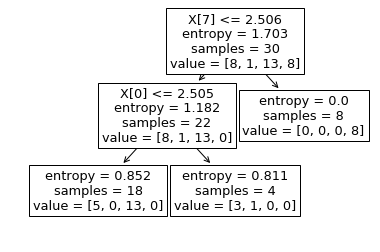

In [120]:
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt

def load_data():
    _data = []
    _target =[]
    _predict = []
    homepath="./dt_debug_testcases/"
    with open(homepath + filename) as f:
        for line in f:
            _temp_list = []
            _label = 0
            _record = line.split()
            _label = int(_record[0])
            
            for i in range(1, len(_record)):    
                _temp_list.append(float(_record[i].split(":")[1]))

            if int(_label) != -1:
                _data.append(_temp_list)
                _target.append(_label)
            else:
                _predict.append(_temp_list)    
                
    return _data,_target,_predict

x,y,z = load_data()

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
clf = clf.fit(x, y)
tree.plot_tree(clf) 
plt.show()

In [121]:
print('leaves: ', leaves)
print('tree attrs: ', tree_attrs)
print('tree thresh: ', tree_thresh)
print('tree values: ', tree_values)

leaves:  {0: 3, 1: 1, 2: 4, 3: 4}
tree attrs:  {0: 7, 1: 0, 2: 0}
tree thresh:  {0: 2.5055623232967914, 1: 2.5054476502503986, 2: 1.0035055101255832}
tree values:  {0: [8, 1, 13, 8], 1: [8, 1, 13], 3: [5, 0, 13], 4: [3, 1, 0], 2: [0, 0, 0, 8], 5: [0, 0, 0, 1], 6: [0, 0, 0, 7]}


In [122]:
node1_attrs = set(range(7))
node1_classes = {}
for classification in train_data:
    for tuple_num in train_data[classification]:
        if tuples[tuple_num][tree_attrs[0]] <= tree_thresh[0]:
            if classification in node1_classes:
                node1_classes[classification].append(tuple_num)
            else:
                node1_classes[classification] = [tuple_num]
# maxGain is incorrect - checking getThresh
entropy = overallInfo(node1_classes)
gains = [0] * 7
threshs = [0]*7
for attr in node1_attrs:
    gain, thresh = getThresh(node1_classes, attr, entropy)
    gains[attr-1] = gain
    threshs[attr-1] = thresh
print(gains)
print(threshs)

# getThresh is incorrect - something with how gain is calculated
#     - calculation of threshold working

[0.2275687876831468, 0.15783883005479682, 0.2052232260422988, 0.3204020720026779, 0.20830760841331686, 0.3241369941322496, 0.3369715254845089]
[1.005952321252586, 1.504771520425495, 3.5068911475830027, 1.00689770940093, 2.0067091339956526, 2.008012809229678, 2.5054476502503986]


In [123]:
nodes = []
split3_nodes_left = []
split3_nodes_right = []
split1_nodes_left = []
split1_nodes_right = []

left_dict1 = splitData(node1_classes, 1.508237074751797, 1, True)
right_dict1 = splitData(node1_classes, 1.508237074751797, 1, False)
left_dict3 = splitData(node1_classes, 1.001301937693715, 3, True)
right_dict3 = splitData(node1_classes, 1.001301937693715, 3, False)

for classification in node1_classes:
    nodes.extend(node1_classes[classification])
    for tuple_num in node1_classes[classification]:
        if tuples[tuple_num][3] <= 1.001301937693715:
            split3_nodes_left.append(tuple_num)
        else:
            split3_nodes_right.append(tuple_num)
        if tuples[tuple_num][1] <= 1.508237074751797:
            split1_nodes_left.append(tuple_num)
        else:
            split1_nodes_right.append(tuple_num)
info_A1 = len(split1_nodes_left)/len(nodes)*overallInfo(left_dict1) + \
          len(split1_nodes_right)/len(nodes)*overallInfo(right_dict1)
info_A3 = len(split3_nodes_left)/len(nodes)*overallInfo(left_dict3) + \
          len(split3_nodes_right)/len(nodes)*overallInfo(right_dict3)
gain1 = overallInfo(node1_classes) - info_A1
gain3 = overallInfo(node1_classes) - info_A3
# assert checks that splitData function works
assert(getLenD(left_dict1) == len(split1_nodes_left))
assert(getLenD(right_dict1) == len(split1_nodes_right))
assert(getLenD(left_dict3) == len(split3_nodes_left))
assert(getLenD(right_dict3) == len(split3_nodes_right))
print(gain1)
print(gain3)

0.1784009321430744
0.03557560929482939
